In [1]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
from httpx import Client
from dataclasses import dataclass, field
from typing import Any
from collections import defaultdict
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx 

In [3]:
source = pd.read_excel('reestr.xlsx')
source.head()

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
0,1,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.10.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
1,2,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.08.2018,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
2,3,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1025204418293,5263039399,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,10.07.2022,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN
3,4,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,1025204411682,5263025484,41.20 Строительство жилых и нежилых зданий,52 - Нижегородская область,NaN,г Нижний Новгород,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,1.0
4,5,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,1037800039276,7801123215,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,10.07.2021,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,NaN


In [4]:
source['Тип субъекта'].unique()

array(['Юридическое лицо', 'Индивидуальный предприниматель'], dtype=object)

In [5]:
source['Категория'].unique()

array(['Не является субъектом МСП', 'Микропредприятие',
       'Малое предприятие', 'Среднее предприятие'], dtype=object)

In [6]:
source = source[
    (source['Тип субъекта'] == 'Юридическое лицо') &
    ((source['Категория'] == 'Малое предприятие') | (source['Категория'] == 'Среднее предприятие')) & 
    source['Основной вид деятельности'].str.startswith('41.20')
]
source.head()

,№ п/п,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности,Регион,Район,Город,...,Дата исключения из реестра,Телефон,E-mail,WWW,Наличие лицензий,"Наличие заключенных договоров, контрактов","Производство инновационной, высокотехнологичной продукции",Участие в программах партнерства,Является социальным предприятием,Среднесписочная численность работников за предшествующий календарный год
19,20,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий,50 - Московская область,Пушкино г,NaN,...,NaN,NaN,NaN,NaN,Нет,Нет,Нет,Нет,Нет,36.0
51,52,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий,50 - Московская область,NaN,г Дзержинский,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,201.0
4652,4653,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",Юридическое лицо,Малое предприятие,1021400692048,1414006922,41.20 Строительство жилых и нежилых зданий,77 - г.Москва,NaN,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,35.0
4667,4668,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",Юридическое лицо,Малое предприятие,1043301806415,3327332190,41.20 Строительство жилых и нежилых зданий,33 - Владимирская область,NaN,г Владимир,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,52.0
4673,4674,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",Юридическое лицо,Малое предприятие,1027807999988,7816061297,41.20 Строительство жилых и нежилых зданий,78 - г.Санкт-Петербург,NaN,NaN,...,NaN,NaN,NaN,NaN,Да,Нет,Нет,Нет,Нет,21.0


In [7]:
@dataclass
class FinancialResult:
    year: int
    current2400: float
    current2410: float
    current2330: float

    @property
    def ebitda(self) -> float:
        return self.current2400 + self.current2410 + self.current2330


@dataclass
class Company:
    address: str
    inn: int
    financial_results: list[FinancialResult] = field(default_factory=list)


def parse_response(response: list[dict[str, Any]]) -> Company:
    address = response[0]['organizationInfo']['address']
    inn = int(response[0]['organizationInfo']['inn'])
    company = Company(address=address, inn=inn)

    for res in response:
        f_result = res['typeCorrections'][0].get('correction', {}).get('financialResult')
        if not f_result:
            continue

        company.financial_results.append(
            FinancialResult(
                year=int(res['period']),
                current2400=f_result.get('current2400', 0),
                current2410=f_result.get('current2410', 0),
                current2330=f_result.get('current2330', 0),
            )
        )

    return company

In [8]:
BASE_URL = 'https://bo.nalog.gov.ru/'
URL_SERCH = 'advanced-search/organizations/search?query={inn}'
URL_BFO = 'nbo/organizations/{id}/bfo'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 6.3; Win64; x64; en-US Trident/4.0)',
}

companies = []

with Client(base_url=BASE_URL, headers=HEADERS) as client:
    for i, inn in enumerate(source['ИНН']):
        try:
            response = client.get(URL_SERCH.format(inn=inn))
            if response.status_code != 200:
                print(f'Cannot get company info with inn={inn}')
                continue
    
            response = response.json()
            if not response.get('content'):
                print(f'Empty company info with inn={inn}')
                continue
    
            response = client.get(URL_BFO.format(id=response['content'][0]['id']))
            if response.status_code != 200:
                print(f'Cannot get the financial results of company with inn={inn}')
                continue
    
            companies.append(parse_response(response.json()))
            print('pass', i + 1, '/', source.shape[0])
        except:
            print(f'Something happens with company with inn={inn}')
            continue

pass 1 / 8927
pass 2 / 8927
pass 3 / 8927
pass 4 / 8927
pass 5 / 8927
pass 6 / 8927
pass 7 / 8927
pass 8 / 8927
pass 9 / 8927
Empty company info with inn=5009106346
pass 11 / 8927
pass 12 / 8927
pass 13 / 8927
pass 14 / 8927
pass 15 / 8927
pass 16 / 8927
pass 17 / 8927
pass 18 / 8927
pass 19 / 8927
pass 20 / 8927
pass 21 / 8927
pass 22 / 8927
pass 23 / 8927
pass 24 / 8927
pass 25 / 8927
pass 26 / 8927
pass 27 / 8927
pass 28 / 8927
pass 29 / 8927
pass 30 / 8927
pass 31 / 8927
pass 32 / 8927
pass 33 / 8927
pass 34 / 8927
pass 35 / 8927
pass 36 / 8927
pass 37 / 8927
pass 38 / 8927
pass 39 / 8927
pass 40 / 8927
pass 41 / 8927
pass 42 / 8927
pass 43 / 8927
pass 44 / 8927
pass 45 / 8927
pass 46 / 8927
pass 47 / 8927
pass 48 / 8927
pass 49 / 8927
pass 50 / 8927
pass 51 / 8927
pass 52 / 8927
pass 53 / 8927
pass 54 / 8927
pass 55 / 8927
pass 56 / 8927
pass 57 / 8927
pass 58 / 8927
pass 59 / 8927
pass 60 / 8927
pass 61 / 8927
pass 62 / 8927
pass 63 / 8927
pass 64 / 8927
pass 65 / 8927
pass 66 / 

In [9]:
ebitdas = defaultdict(float)
company_counts = defaultdict(int)
for com in companies:
    for f_result in com.financial_results:
        ebitdas[f_result.year] += f_result.ebitda
        company_counts[f_result.year] += 1

avg_ebitdas = {}
for k, v in ebitdas.items():
    avg_ebitdas[k] = v / company_counts[k]

avg_ebitdas

{2024: 16324.71628882191,
 2023: 12918.507045705182,
 2022: 10026.490727862772,
 2021: 8119.417537537537,
 2020: 7998.874060382009}

Вывод: с каждым годом EBITDA в среднем растет, а значит, это выгодно

In [16]:
d = {'year': [], 'inn': [], 'proc_profit': [], 'address': [], 'profit': []}
for com in companies:
    com.financial_results.sort(key=lambda x: x.year)
    for i in range(1, len(com.financial_results)):
        if com.financial_results[i - 1].current2400 == 0:
            continue
        d['year'].append(com.financial_results[i].year)
        d['inn'].append(com.inn)
        d['proc_profit'].append(
            (com.financial_results[i].current2400 - com.financial_results[i - 1].current2400) / abs(com.financial_results[i - 1].current2400) * 100
        )
        d['address'].append(com.address)
        d['profit'].append(com.financial_results[i].current2400)
        

In [17]:
df = pd.DataFrame.from_dict(d)

In [18]:
df.head()

,year,inn,proc_profit,address,profit
0,2021,5038038838,136.052909,"141207, Московская обл, г Пушкино, ул Чехова, ...",3080.0
1,2022,5038038838,533.701299,"141207, Московская обл, г Пушкино, ул Чехова, ...",19518.0
2,2023,5038038838,-207.147249,"141207, Московская обл, г Пушкино, ул Чехова, ...",-20913.0
3,2024,5038038838,3.748864,"141207, Московская обл, г Пушкино, ул Чехова, ...",-20129.0
4,2021,5027006369,-31.203998,"140093, Московская обл, Дзержинский г, Угрешск...",20376.0


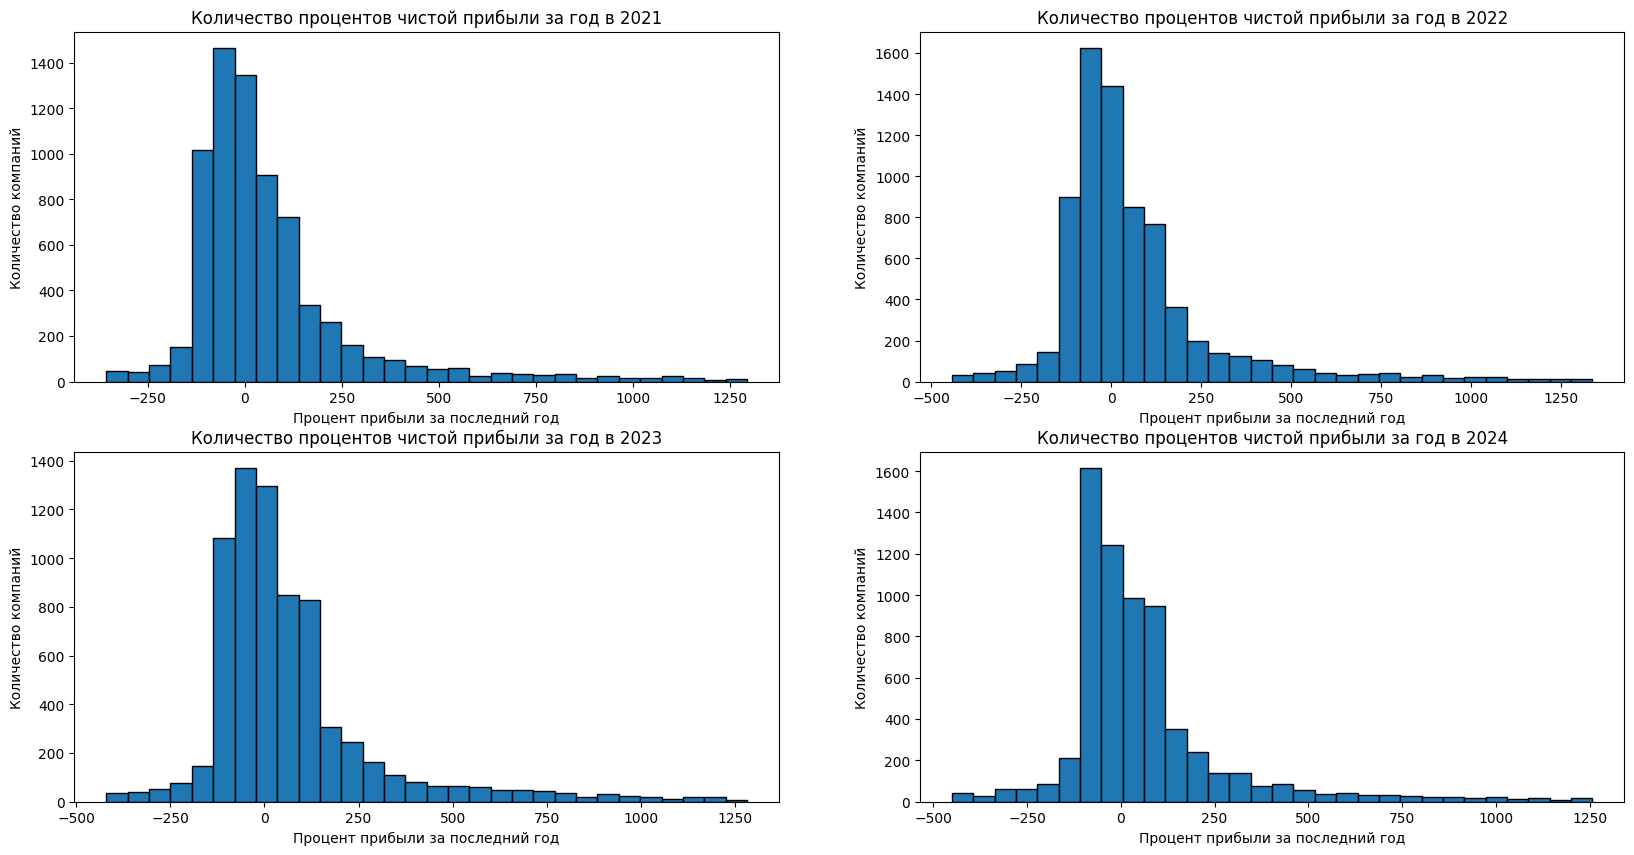

In [19]:

df1 = df[df['year'] == 2021].reset_index()
df1 = df1[(df1['proc_profit'] < df1['proc_profit'].quantile(0.95)) & (df1['proc_profit'] > df1['proc_profit'].quantile(0.05))]

df2 = df[df['year'] == 2022].reset_index()
df2 = df2[(df2['proc_profit'] < df2['proc_profit'].quantile(0.95)) & (df2['proc_profit'] > df2['proc_profit'].quantile(0.05))]

df3 = df[df['year'] == 2023].reset_index()
df3 = df3[(df3['proc_profit'] < df3['proc_profit'].quantile(0.95)) & (df3['proc_profit'] > df3['proc_profit'].quantile(0.05))]

df4 = df[df['year'] == 2024].reset_index()
df4 = df4[(df4['proc_profit'] < df4['proc_profit'].quantile(0.95)) & (df4['proc_profit'] > df4['proc_profit'].quantile(0.05))]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0][0].hist(df1['proc_profit'], bins=30, edgecolor='black')
axes[0][0].set_title('Количество процентов чистой прибыли за год в 2021')
axes[0][0].set_xlabel('Процент прибыли за последний год')        
axes[0][0].set_ylabel('Количество компаний') 

axes[0][1].hist(df2['proc_profit'], bins=30, edgecolor='black')
axes[0][1].set_title('Количество процентов чистой прибыли за год в 2022')
axes[0][1].set_xlabel('Процент прибыли за последний год')         
axes[0][1].set_ylabel('Количество компаний') 

axes[1][0].hist(df3['proc_profit'], bins=30, edgecolor='black')
axes[1][0].set_title('Количество процентов чистой прибыли за год в 2023')
axes[1][0].set_xlabel('Процент прибыли за последний год')         
axes[1][0].set_ylabel('Количество компаний') 

axes[1][1].hist(df4['proc_profit'], bins=30, edgecolor='black')
axes[1][1].set_title('Количество процентов чистой прибыли за год в 2024')
axes[1][1].set_xlabel('Процент прибыли за последний год')         
axes[1][1].set_ylabel('Количество компаний') 

plt.show()

Много компаний из года в год уменьшают прибыль

In [20]:
df5 = df[df['year'] == 2024].reset_index()
df5 = df5[(df5['profit'] < df5['profit'].quantile(0.95)) & (df5['profit'] > df5['proc_profit'].quantile(0.05))]
df5 = df5.sort_values(by='profit', ascending=False).head(100)
df5.head()

,index,year,inn,proc_profit,address,profit
4211,17929,2024,7709483054,99.126003,"105064, Москва г, ул. Казакова, д. 8, стр. 2, ...",91817.0
3552,15099,2024,7203193368,735.096986,"625003, Тюменская обл, г Тюмень, ул Победы, д ...",91702.0
3839,16340,2024,4823074654,-60.024459,"398005, Липецкая обл, г Липецк, ул Алмазная, в...",91524.0
2864,12172,2024,8610017257,0.816768,"628126, Ханты-Мансийский Автономный округ - Юг...",91341.0
834,3518,2024,7536158377,16.141913,"672027, Забайкальский край, г. Чита, ул. Бутин...",91039.0


In [21]:
API_KEY = "<API_KEY_FROM_YANDEX_GEOCODER>"

with Client(base_url="https://geocode-maps.yandex.ru/v1") as client:
    def get_coords(address):
        try:
            response = client.get(
                "",
                params={
                    "apikey": API_KEY,
                    "geocode": address,
                    "format": "json",
                },
            )
            response = response.json()
            return pd.Series(
                list(
                    map(
                        float, 
                        response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split()
                    )
                )[::-1]
            )
        except Exception as e:
            print(f"Ошибка при обработке адреса '{address}': {e}")
        return pd.Series([None, None])
    
    df5[['latitude', 'longitude']] = df5['address'].apply(get_coords)



In [22]:
df5.head()

,index,year,inn,proc_profit,address,profit,latitude,longitude
4211,17929,2024,7709483054,99.126003,"105064, Москва г, ул. Казакова, д. 8, стр. 2, ...",91817.0,55.762687,37.661221
3552,15099,2024,7203193368,735.096986,"625003, Тюменская обл, г Тюмень, ул Победы, д ...",91702.0,57.153439,65.519811
3839,16340,2024,4823074654,-60.024459,"398005, Липецкая обл, г Липецк, ул Алмазная, в...",91524.0,52.567622,39.660503
2864,12172,2024,8610017257,0.816768,"628126, Ханты-Мансийский Автономный округ - Юг...",91341.0,62.529531,65.593509
834,3518,2024,7536158377,16.141913,"672027, Забайкальский край, г. Чита, ул. Бутин...",91039.0,52.046809,113.512997


In [23]:
df5 = df5.dropna(subset=['latitude', 'longitude'])
geometry = [Point(xy) for xy in zip(df5['longitude'], df5['latitude'])]
gdf = gpd.GeoDataFrame(df5, geometry=geometry, crs="EPSG:4326")

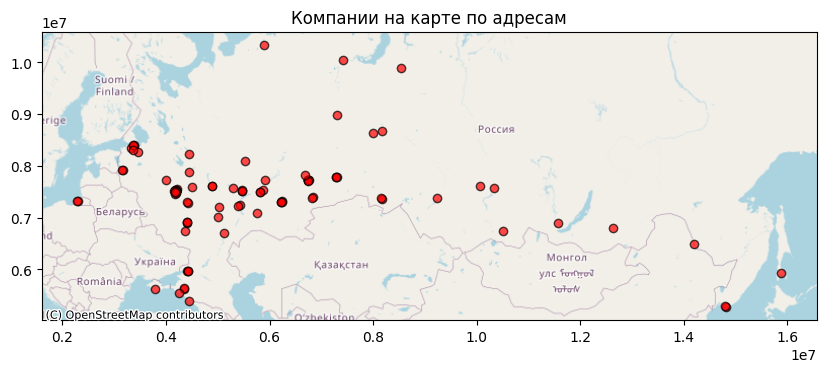

In [24]:
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10, 10), color='red', alpha=0.7, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Компании на карте по адресам")
plt.show()